<a href="https://colab.research.google.com/github/diptaban/MLP_Multiclass_CustomData_Pytorch/blob/main/MLP_Multiclass_CustomData_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(50000, 2)
(50000,)
(50000, 1)
(50000, 3)
2
3
[0 1 2]


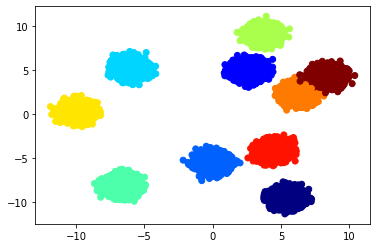

In [95]:
import numpy as np
import torch
from torchvision import datasets, transforms

from sklearn.datasets import make_blobs
clstr_centers = 10
train_samples = 50000
test_samples = 100
spread = 0.5
rndm_state = 10

x_train, y_train = make_blobs(n_samples=train_samples, centers=clstr_centers,\
                       cluster_std=spread, random_state=rndm_state)
x_test, y_test = make_blobs(n_samples=test_samples, centers=clstr_centers,\
                       cluster_std=spread, random_state=rndm_state)


print(x_train.shape)
print(y_train.shape)

import matplotlib.pyplot as plt
plt.scatter(x_train[:,0],x_train[:,1],c = y_train, cmap ='jet')
#plt.scatter(x_test[:,0],x_test[:,1],c = y_test,cmap ='viridis')

y_train = np.expand_dims(y_train, axis=1)
print(y_train.shape)

Design_Matrix = np.concatenate((x_train,y_train),axis=1)
print(Design_Matrix.shape)
np.savetxt('train_data.txt', Design_Matrix, delimiter='\t')

print(x_train.shape[1])
print(Design_Matrix.shape[1])

print(np.arange(Design_Matrix.shape[1]))

In [96]:

class Dataset_1(torch.utils.data.Dataset):
  
  def __init__(self, src_file, n_rows=None):
    all_xy = np.loadtxt(src_file, max_rows=n_rows,
      usecols=np.arange(Design_Matrix.shape[1]), delimiter="\t",
      skiprows=0, comments="#", dtype=np.float32)

    n = len(all_xy)
    tmp_x = all_xy[0:n,0:x_train.shape[1]]  # all rows, cols [0,2)
    tmp_y = all_xy[0:n,x_train.shape[1] ]   # 1-D required

    self.x_data = \
      torch.tensor(tmp_x, dtype=torch.float32)
    self.y_data = \
      torch.tensor(tmp_y, dtype=torch.int64)

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    preds = self.x_data[idx]
    trgts = self.y_data[idx] 
    sample = { 
      'predictors' : preds,
      'targets' : trgts
    }
    return preds,trgts


In [97]:
train_file = "/content/train_data.txt"
train_ds = Dataset_1(train_file, n_rows=train_samples) 

#test_file = ".\\Data\\students_test.txt"
#test_ds = Dataset_1(test_file)  # all 40 rows

bat_size = 32
train_loader = torch.utils.data.DataLoader(train_ds,
  batch_size=bat_size, shuffle=True)

for (X_train, Y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', Y_train.size(), 'type:', Y_train.type())
    #print(X_train)
    break

X_train: torch.Size([32, 2]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


In [98]:
class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_size1,hidden_size2, hidden_size3, output_size):
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.hidden_size1  = hidden_size1
            self.hidden_size2 = hidden_size2
            self.hidden_size3 = hidden_size3
            self.output_size = output_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size1)
            self.relu1 = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size1, self.hidden_size2)
            self.relu2 = torch.nn.ReLU()
            self.fc3 = torch.nn.Linear(self.hidden_size2,self.hidden_size3)
            self.relu3 = torch.nn.ReLU()
            self.fc4 = torch.nn.Linear(self.hidden_size3,self.output_size)
           
        def forward(self, x):
            z1 = self.fc1(x)
            a1 = self.relu1(z1)
            z2 = self.fc2(a1)
            a2 = self.relu2(z2)
            z3 = self.fc3(a2)
            a3 = self.relu3(z3)
            z4 = self.fc4(a3)
            a4 = torch.nn.functional.log_softmax(z4,dim=1) #not needed if 
            # nn.CrossEntropyLoss() is used
            return a4


model = Feedforward(2,60,40,20,10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = torch.nn.CrossEntropyLoss()


In [99]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data
        target = target

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [100]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in train_loader:
        data = data
        target = target
        output = model(data)
        #print(output.shape)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(train_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(train_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(train_loader.dataset), accuracy))

In [101]:
epochs = 10
lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.309499
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.364959
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.222728
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.189507
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.152239
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.130957
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.142165
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.087580

Validation set: Average loss: 0.0762, Accuracy: 48887/50000 (98%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.026017
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.021768
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.013379
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.027787
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.156836
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.059379
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.007813
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.016136

Validation set: Average loss: 0.0297, Accuracy: 49607/50000 (99%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.094479
Train Epoch: 3 [6400/50000 (13%

In [102]:
for data,target in train_loader:
  output = model(data)
  pred1 = (output.data)
  print(pred1)
  pred =  pred1.max(1)
  print(pred)
  break

tensor([[-1.3739e+01, -4.0078e+01, -2.6091e+01, -2.8941e+01, -4.3966e+01,
         -7.9025e+01, -3.9606e+01, -9.0731e+00, -1.1575e-04, -3.1789e+01],
        [-3.9320e+01, -7.8168e+00, -3.4399e+01, -2.3161e+01, -3.3011e+01,
         -4.0308e-04, -3.3926e+01, -4.6107e+01, -4.6617e+01, -1.7352e+01],
        [-1.8429e+01, -1.7555e+01, -2.2352e+01, -2.3929e+01, -3.0774e+01,
         -4.5440e+01, -2.6622e+01, -2.7748e-04, -8.1992e+00, -1.2856e+01],
        [-1.5697e+01, -1.1813e+01, -1.8865e+01, -2.0044e+01, -2.6453e+01,
         -3.3418e+01, -2.2880e+01, -1.1442e-02, -1.0020e+01, -4.4808e+00],
        [-2.3594e+01, -1.1383e+01, -1.8747e+01, -4.8994e-05, -2.0446e+01,
         -1.4182e+01, -1.0206e+01, -3.0389e+01, -1.9166e+01, -2.2788e+01],
        [-4.4282e+01, -1.0368e+01, -3.9219e+01, -2.6781e+01, -3.7648e+01,
         -3.1471e-05, -3.8767e+01, -5.3474e+01, -5.3601e+01, -1.9582e+01],
        [-6.9487e+00, -3.2219e+01, -1.7112e+01, -2.1843e+01, -3.4497e+01,
         -6.6586e+01, -3.1398e+0

In [103]:
print(x_train.shape)
x_train = torch.FloatTensor(x_train)
op = model(x_train)
pred1 = (op)
#print(pred1)
pred =  pred1.max(1)[1]
print(pred)

(50000, 2)
tensor([0, 9, 5,  ..., 1, 1, 6])


xx shape: (266, 263)
(69958, 2)
torch.Size([69958, 2])
torch.Size([69958])
(266, 263)


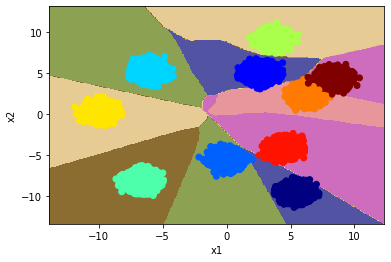

In [104]:
import numpy as np
# Plotting Decision Boundary
X = x_train.T
X = X.T
 # Set min and max values and give it some padding
x_min, x_max = X[:,0].min() -2 , X[:,0].max() + 2
y_min, y_max = X[:,1].min() -2, X[:,1].max() + 2
h = 0.1

# Generate a grid of points with distance h between them
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Predict the function value for the whole grid
print('xx shape:', xx.shape)
Xn = (np.c_[xx.ravel(),yy.ravel()])
print(Xn.shape)
Xn = torch.FloatTensor(Xn)
print(Xn.shape)
#P = predict(W1,W2,b1,b2,Xn)
P = (model(Xn)) # prediction of all points in the meshgrid
P = P.max(1)[1]

PP = P.detach().numpy()
print(P.shape)
PP = PP.reshape(xx.shape)
print(PP.shape)

plt.contourf(xx, yy, PP, cmap='tab20b')
plt.ylabel('x2')
plt.xlabel('x1')

plt.scatter(x_train[:,0],x_train[:,1],c = y_train, cmap ='jet')